## 다중분류

### 소프트맥스와 다중분류

- 로지스틱회귀는 두 개의 선택지(0과 1) 중 하나를 고르는 문제 - 3개 이상 선택지가 필요하다면?

#### 소프트맥스 함수
- 하나의 샘플 데이터 예측값이 가능한 정답지 확률의 합이 1이 되도록 함
- 붓꽃 데이터 Setosa, Vericolor, Virginica 
    - 꽃받침 길이: 7.0, 꽃받침 폭: 3.2, 꽃잎 길이: 4.7, 꽃잎 폭: 1.4 라면
    - Setosa일 확률: 0.22, Vericolor일 확률: 0.58, Virginica일 확률 0.2 
    - 결론은 Vericolor일 확률이 가장 높다!


    $$  P_{i} = \frac{e^{z_{i}}}{\sum_{j=1}^{k} e^{z_{j}}} $$


#### 다중분류 연습

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
x_train = [[1,2,1,1],
           [2,1,3,2],
           [3,1,3,4],
           [4,1,5,5],
           [1,7,5,5],
           [1,2,5,6],
           [1,6,6,6],
           [1,7,7,7],
          ]
y_train = [2,2,2,1,1,1,0,0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [5]:
model = nn.Linear(4, 3)  ## 4개의 특징에 3개의 분류값

optimizer = optim.SGD(model.parameters(), lr=0.1)
nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    prediction = model(x_train)
    cost = F.cross_entropy(prediction, y_train)  ## cross_entropy 함수 내 softmax 연산포함

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch:4d}/{nb_epochs} Cost: {cost.item():6f}')

Epoch    0/1000 Cost: 2.126690
Epoch  100/1000 Cost: 0.697719
Epoch  200/1000 Cost: 0.615936
Epoch  300/1000 Cost: 0.558678
Epoch  400/1000 Cost: 0.508208
Epoch  500/1000 Cost: 0.460482
Epoch  600/1000 Cost: 0.413972
Epoch  700/1000 Cost: 0.367965
Epoch  800/1000 Cost: 0.322272
Epoch  900/1000 Cost: 0.278013
Epoch 1000/1000 Cost: 0.244805


In [14]:
new_var = torch.FloatTensor([[4,1,5,5]])
y_pred = F.softmax(model(new_var), dim=1)

print(f'입력에 {new_var}에 대한 예측값: {y_pred.data} ')
print(f'입력에 {new_var}에 대한 클래스: {y_pred.argmax().item()} ')

입력에 tensor([[4., 1., 5., 5.]])에 대한 예측값: tensor([[2.6719e-05, 7.7926e-01, 2.2072e-01]]) 
입력에 tensor([[4., 1., 5., 5.]])에 대한 클래스: 1 


### 데이터셋 분리 / 교차검증

- Training Set와 Test Set으로 보통 작업을 하지만
- 검증을 위해 Validation Set를 학습과정에 사용 - 하이퍼파라미터 튜닝용

    <img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/refs/heads/main/images/torch0010.png" width="800">


- 보통 Training / Test 를 8:2, 7:3 정도로 배분
- Training : Validation : Test의 경우는 6:2:2 정도의 비율르 배분 추천

#### 교차검증
- 별도의 검증집합이 없는 상황에 유용한 모델 선택 기법
- 훈련집합을 등분, 학습과 평가 과정을 여러번 반복한 후 평균 사용
- K-fold cross validation

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import random

In [16]:
iris = load_iris()
X = iris['data']
Y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

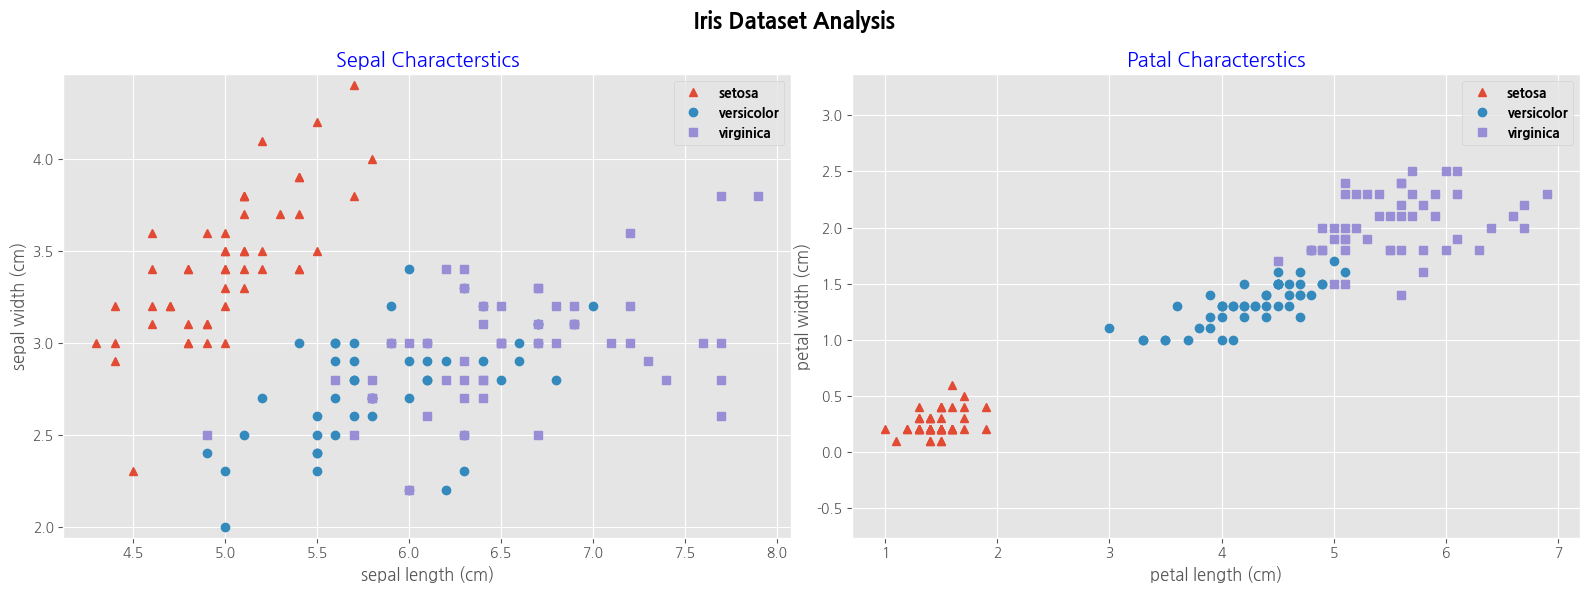

In [56]:
from matplotlib import font_manager

plt.style.use('ggplot')  ## 다크테마 설정 : dark_background, ggplot

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.grid'] = True

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('Sepal Characterstics', color='blue')
ax2.set_title('Patal Characterstics', color='blue')

# 전체 subplot 공통 타이틀
fig.suptitle("Iris Dataset Analysis", fontsize=16, color='black', fontweight='bold')

# 클래스별 마커 스타일 지정
markers = ['^', 'o', 's']  # 삼각형, 원형, 사각형

# Legend 글자색 변경
font_props = font_manager.FontProperties(size=10, weight="bold")

for target, target_name in enumerate(names):
    X_plot = X[Y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker=markers[target], label=target_name)
    ax1.set_xlabel(feature_names[0])
    ax1.set_ylabel(feature_names[1])
    ax1.axis('equal')
    ax1.legend(prop=font_props, labelcolor="black")

for target, target_name in enumerate(names):
    X_plot = X[Y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker=markers[target], label=target_name)
    ax2.set_xlabel(feature_names[2])
    ax2.set_ylabel(feature_names[3])
    ax2.axis('equal')
    ax2.legend(prop=font_props, labelcolor="black")

plt.tight_layout()
plt.show()

##### 데이터셋 준비

In [57]:
class MyIrisDataset(Dataset):
    def __init__(self, x_data, y_data):
        # super().__init__()
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        # return super().__getitem__(index)
        return self.x_data[index].astype(np.float32), self.y_data[index].astype(np.int64)
    
    def __len__(self):
        return len(self.x_data)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2, shuffle=True
)

In [60]:
train_dataset = MyIrisDataset(x_train, y_train)
test_dataset = MyIrisDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False, drop_last=False)

##### 학습

In [72]:
model = nn.Linear(4, 3)
criterion = nn.CrossEntropyLoss()  ## 내부 소프트맥스함수 포함
optimizer = optim.SGD(model.parameters(), lr=0.06)

In [75]:
nb_epochs = 1000
for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_dataloader)

    for idx, (x_train, y_train) in enumerate(train_dataloader):
        optimizer.zero_grad()  # 역전파를 위해 기울기 초기화 
        hypothesis = model(x_train)
        cost = criterion(hypothesis, y_train) # 손실 함수(loss function)를 사용하여 모델의 예측값과 실제 값 간의 차이를 계산
        cost.backward() # 역전파 수행
        optimizer.step() # 모델 파라미터 업데이트

        avg_cost += cost / total_batch
    
    print(f'Epoch: {epoch+1:04d}, Cost: {avg_cost:.9f}')

print('Learning finished')

Epoch: 0001, Cost: 0.064601712
Epoch: 0002, Cost: 0.072330959
Epoch: 0003, Cost: 0.067794681
Epoch: 0004, Cost: 0.061915085
Epoch: 0005, Cost: 0.068648681
Epoch: 0006, Cost: 0.063093565
Epoch: 0007, Cost: 0.066901319
Epoch: 0008, Cost: 0.068012521
Epoch: 0009, Cost: 0.069676407
Epoch: 0010, Cost: 0.066814065
Epoch: 0011, Cost: 0.068046533
Epoch: 0012, Cost: 0.067690037
Epoch: 0013, Cost: 0.064999036
Epoch: 0014, Cost: 0.065433010
Epoch: 0015, Cost: 0.064184807
Epoch: 0016, Cost: 0.069439329
Epoch: 0017, Cost: 0.066003561
Epoch: 0018, Cost: 0.069093555
Epoch: 0019, Cost: 0.072288416
Epoch: 0020, Cost: 0.061119005
Epoch: 0021, Cost: 0.067821652
Epoch: 0022, Cost: 0.064829364
Epoch: 0023, Cost: 0.063779920
Epoch: 0024, Cost: 0.064609639
Epoch: 0025, Cost: 0.065632008
Epoch: 0026, Cost: 0.066096224
Epoch: 0027, Cost: 0.063959859
Epoch: 0028, Cost: 0.063844316
Epoch: 0029, Cost: 0.069332041
Epoch: 0030, Cost: 0.063004218
Epoch: 0031, Cost: 0.065050863
Epoch: 0032, Cost: 0.065871589
Epoch: 0

##### 테스트셋을 이용한 성능검증

- with torch.no_grad() - gradient 연산 옵션을 끌 때 사용하는 파이선 컨텍스트 매니저. 

In [76]:
# 테스트 데이터 사용 모델 테스트
correct_prediction_list = []

with torch.no_grad(): # gradient 계산을 수행하지 않음
    for idx, (x_test, y_test) in enumerate(test_dataloader):
        prediction = model(x_test)
        correct_prediction = torch.argmax(prediction, 1) == y_test
        correct_prediction_list.append(correct_prediction)
    
    correct_prediction_list = torch.cat(correct_prediction_list, dim=0)
    accuracy = correct_prediction_list.float().mean()
    print(f'Accuracy: {accuracy.item()}')


Accuracy: 1.0


### 오픈 데이터셋 이용 소프트맥스 회귀 연습

#### MNIST 데이터셋
- NIST(National Institute of Standards and Technology)로 미국 국립표준연구소에서 데이터셋을 뽑아놓은 것으로 기본 손글씨 데이터셋임
- Fashin-MNIST로 옷과 신발에 대한 데이터셋 등 종류가 많음

- 0 ~ 9 까지 이미지로 구성된 손글씨 데이터
- 60,000 장의 training set과 10,000 장의 test set으로 구성

#### TorchVision 사용
- Pytorch에서 사용하는 Computer vision 용 라이브러리


In [77]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random

In [78]:
USE_CUDA = torch.cuda.is_available() ## GPU 사용가능하면 True
USE_CUDA

True

In [79]:
device = torch.device('cuda' if USE_CUDA else 'cpu')
print(f'Training device : {device}')

# hyperparameters
training_epochs = 15
batch_size = 100

Training device : cuda


##### 데이터셋 준비

In [80]:
# MNIST dataset
mnist_train = dsets.MNIST(root='./MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root='./MNIST_data/', train=False, transform=transforms.ToTensor(), download=True)

## dataset loader / 배치크기는 100
data_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:12<00:00, 790574.89it/s] 


Extracting ./MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 149471.63it/s]


Extracting ./MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1697135.02it/s]


Extracting ./MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2271706.27it/s]

Extracting ./MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST\raw



##### 모델, 목적합수, 옵티마이저 준비

In [81]:
# MNIST data image of shape 28 * 28 = 784
model = nn.Linear(784, 10, bias=True).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

##### 학습

In [82]:
for epoch in range(training_epochs): ## 앞서 training_epochs 값은 15로 지정
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치크키가 100이므로 아래의 연산에서 X는 (100, 784) 텐서가 됨
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0~9의 정수
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    
    print(f'Epoch: {epoch+1:04d}, Cost={avg_cost:.9f}')

print('Learning finished!')

Epoch: 0001, Cost=0.534806073
Epoch: 0002, Cost=0.358880937
Epoch: 0003, Cost=0.330819219
Epoch: 0004, Cost=0.316129357
Epoch: 0005, Cost=0.306829840
Epoch: 0006, Cost=0.300060928
Epoch: 0007, Cost=0.294915974
Epoch: 0008, Cost=0.290860176
Epoch: 0009, Cost=0.287403375
Epoch: 0010, Cost=0.284373701
Epoch: 0011, Cost=0.281970710
Epoch: 0012, Cost=0.279861361
Epoch: 0013, Cost=0.277815640
Epoch: 0014, Cost=0.275918305
Epoch: 0015, Cost=0.274501920
Learning finished!


##### 테스트

In [83]:
# 테스트 데이터를 사용하여 모델을 테스트함
with torch.no_grad():  ## torch.no_grad() 하면 gradiente 계산을 수행안함
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device=device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print(f'Accuracy {accuracy.item()}')

Accuracy 0.8840000033378601


c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Label: 7
Prediction: 7


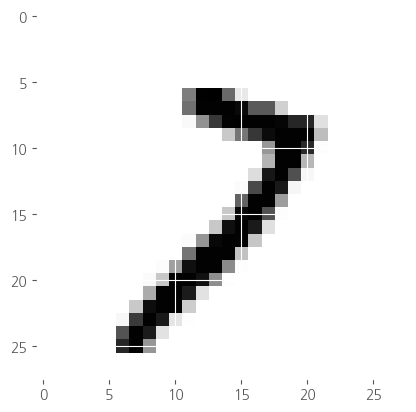

In [91]:
# 테스트 데이터를 사용하여 모델을 테스트함
with torch.no_grad():  ## torch.no_grad() 하면 gradiente 계산을 수행안함
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r].to(device)

    print(f'Label: {Y_single_data.item()}')
    single_prediction = model(X_single_data)
    print(f'Prediction: {torch.argmax(single_prediction, 1).item()}')
    
    plt.imshow(mnist_test.test_data[r].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()